# Table of contents
1. [Data Setup](#setup)
2. [Block Interactions per Call](#q15)
    1. [Among Listeners](#q15_listeners)
    2. [Among Non-Listeners](#q15_nonlisteners)
    3. [Key Takeaways](#q15_keytakeaways)

## Data Setup <a name="setup"></a>

In [ ]:
#packages----
#data connection
library(bigrquery)
library(dbplyr)
library(dplyr)
library(lubridate) #for date transformations
library(ggplot2)
library(viridis) #ggplot colour
library(ggthemes)


In [ ]:
#Raw data extraction for Mali----
bq_auth(path = "jsonkey/viamo-datakind-19b12e3872f5.json")
con <- DBI::dbConnect(
  bigrquery::bigquery(),
  project = "viamo-datakind", 
  dataset = "datadive", 
  bigint = "integer64",
  billing = "viamo-datakind"
)
con
dbListTables(con)

raw_data <- tbl(con, "321_sessions_1122")
data_mali <- raw_data %>% 
  select(organization_country, 
         call_id, 
         call_date,
         block_interaction_id, 
         duration_listened_seconds, 
         block_audio_percent_listened, 
         block_title, block_theme, 
         block_topic, km_block_reached, 
         km_block_listened,
         listener) %>%
  #extracting day from date - to check difference btw weekdays/weekends
  # mutate(call_day = format(call_date, format = "%d")) %>% 
  #mutate(call_day = wday(call_date, week_start = 1)) %>% 
  filter(organization_country == "Mali") 

# Block Interactions per Call <a name="q15"></a>
## Among Listeners <a name="q15_listeners"></a>

Warning message:
"Removed 162 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_col()`)."


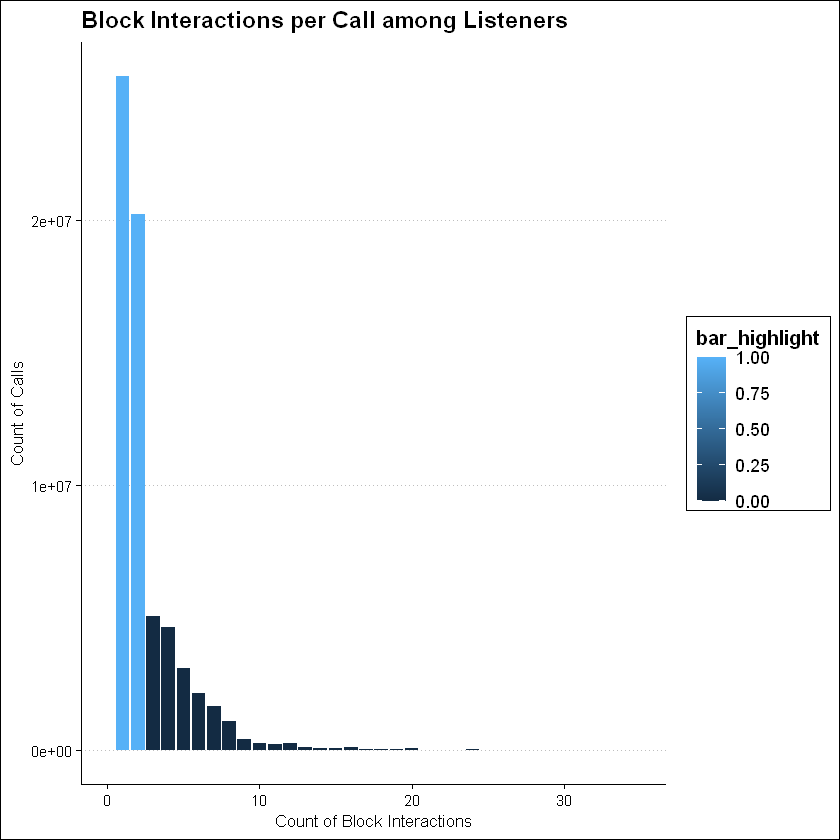

In [5]:
#15:Block interaction distn.----
#Q15: Within an individual call (call_id), what is the distribution 
# of the number of block interaction ids that occur within a single call?

##Listeners----
###Data----
#limiting data to the context of the question
data_blk_int_list <-  data_mali %>% 
  filter(!is.null(listener)) %>% 
  group_by(call_id) %>% 
  summarise(n_blk_int = n_distinct(block_interaction_id)) %>% 
  ungroup() %>% 
  group_by(n_blk_int) %>% 
  summarise(n_call = n_distinct(call_id)) %>% collect

#assigning the right data class
data_blk_int_list$p_call <- round(data_blk_int_list$n_call/sum(data_blk_int_list$n_call), 2)
data_blk_int_list$n_blk_int <- as.numeric(data_blk_int_list$n_blk_int)
data_blk_int_list$n_call <- as.numeric(data_blk_int_list$n_call)

###vizualization----
#barplot version of hist since data is too huge for the expanded version
#for viz - bar highlights
data_blk_int_list$bar_highlight <- 0
data_blk_int_list$bar_highlight[data_blk_int_list$p_call >= 0.3] <- 1
# colours <- c("#595959", "blue")

plot_blk_int_list <- ggplot(data_blk_int_list, aes(x=n_blk_int, y=n_call)) +
  geom_col(aes(fill=bar_highlight)) +
  scale_x_continuous(limits = c(0, 35), name = "Count of Block Interactions") +
  scale_y_continuous(name = "Count of Calls") +
  ggtitle("Block Interactions per Call among Listeners") +
  theme_clean() 

plot_blk_int_list

### Key observations: 
- 39% of the calls have a single block interaction (highlighted in blue)
- 31% have 2 block interactions (highlighted in blue)
<div class="alert alert-block alert-warning">DATA SANITY CHECK: Maximum block interactions in a single call is 1154 - How probable is this outcome? Does this make sense?
</div>

## Among Non-Listeners <a name="q15_nonlisteners"></a>

Warning message:
"Removed 180 rows containing missing values (`position_stack()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_col()`)."


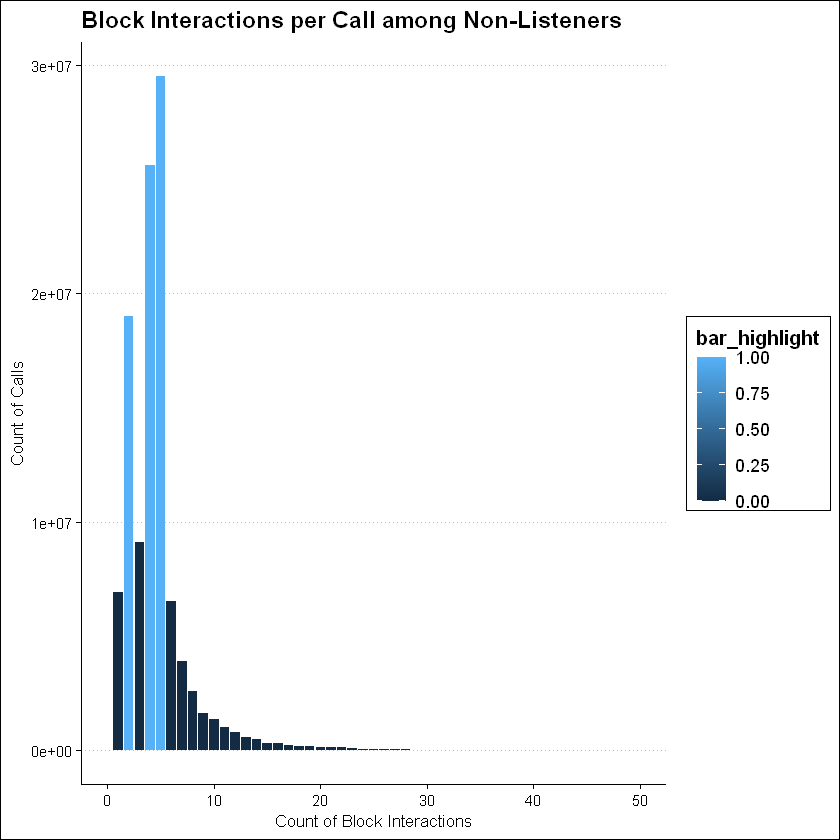

In [6]:
###Data----
#limiting data to the context of the question
data_blk_int_nonlist <-  data_mali %>% 
  filter(is.null(listener)) %>% 
  group_by(call_id) %>% 
  summarise(n_blk_int = n_distinct(block_interaction_id)) %>% 
  ungroup() %>% 
  group_by(n_blk_int) %>% 
  summarise(n_call = n_distinct(call_id)) %>% collect

#assigning the right data class
data_blk_int_nonlist$p_call <- round(data_blk_int_nonlist$n_call/sum(data_blk_int_nonlist$n_call), 2)
data_blk_int_nonlist$n_blk_int <- as.numeric(data_blk_int_nonlist$n_blk_int)
data_blk_int_nonlist$n_call <- as.numeric(data_blk_int_nonlist$n_call)

data_blk_int_nonlist <- data_blk_int_nonlist %>% 
  arrange(desc(n_call))

###vizualization----
#barplot version of hist since data is too huge for the expanded version
#for viz - bar highlights
data_blk_int_nonlist$bar_highlight <- 0
data_blk_int_nonlist$bar_highlight[data_blk_int_nonlist$p_call >= 0.1] <- 1
# colours <- c("#595959", "blue")

plot_blk_int_nonlist <- ggplot(data_blk_int_nonlist, aes(x=n_blk_int, y=n_call)) +
  geom_col(aes(fill=bar_highlight)) +
  scale_x_continuous(limits = c(0, 50), name = "Count of Block Interactions") +
  scale_y_continuous(name = "Count of Calls") +
  ggtitle("Block Interactions per Call among Non-Listeners") +
  theme_clean() 

plot_blk_int_nonlist

### Key observations: 
- 74% of the non-listerners have 2-5 block interactions per call (highlighted in blue).
    - That is, 26% of non-listerners have 5 block interactions, 23% have 4, 17% have 2 block interactions 
<div class="alert alert-block alert-warning">DATA SANITY CHECK: Again, the maximum block interactions in a single call is 995 - How probable is this outcome? Does this make sense? </div>


## Key Takeaways <a name="q15_keytakeaways"></a>
- Interestingly, **Non-listeners have more block interactions per call than listerners.**<br>
    - Does this mean that listerers are more accurate with their selections (quick call start -> to value received)? <br>
    - Conversely, indicating that non-listeners go through multiple blocks, listening to less than 75% of the audio each time, but fail to be convinced of the value of the platform? <br>
   Here, it is worthy to spend some time evaluating the 75% threshold between a listerner & non-listerner. <br>
    - How probable is it that callers receive the desired information before listening to 75% of the audio?  <br>
    Could this explain the higher number of block interactions among those currently tagged as non-listerners? <br>
    <- METRIC DEFINITION RECHEK (parked for later)